# Build MI Network from types and samples

## Libs

In [1]:
import os
import scanpy as sc
from itertools import compress
import pandas as pd
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'

## Check datas

Check for which dests we have combined embeds, and just the query objects

In [2]:
backup_h5ds = os.listdir(backup_dir)
latent_h5ds = list(compress(backup_h5ds,['latent' in h5d for h5d in backup_h5ds]))
query_h5ds = list(compress(backup_h5ds,['query' in h5d for h5d in backup_h5ds]))
combined_h5ds = list(compress(backup_h5ds,['combined' in h5d for h5d in backup_h5ds]))
filter_h5ds = list(compress(backup_h5ds,['filtered' in h5d for h5d in backup_h5ds]))

In [43]:
print(len(filter_h5ds))
filter_h5ds

13


['filtered_Lambrechts_2018_LUAD_6653.h5ad',
 'filtered_Zilionis_Klein_2019_NSCLC.h5ad',
 'filtered_Lambrechts_2018_LUAD_6149v1.h5ad',
 'filtered_UKIM-V-2.h5ad',
 'filtered_Kim_Lee_2020_LUAD.h5ad',
 'filtered_UKIM-V.h5ad',
 'filtered_Goveia_Carmeliet_2020_NSCLC.h5ad',
 'filtered_Maynard_Bivona_2020_NSCLC.h5ad',
 'filtered_He_Fan_2021_LUAD.h5ad',
 'filtered_Wu_Zhou_2021_NSCLC.h5ad',
 'filtered_Chen_Zhang_2020_NSCLC.h5ad',
 'filtered_Laughney_Massague_2020_NSCLC.h5ad',
 'filtered_Lambrechts_2018_LUAD_6149v2.h5ad']

In [38]:
query_h5ds

['query_Laughney_Massague_2020_NSCLC.h5ad',
 'query_Goveia_Carmeliet_2020_NSCLC.h5ad',
 'query_Lambrechts_2018_LUAD_6149v1.h5ad',
 'query_Zilionis_Klein_2019_NSCLC.h5ad',
 'query_Lambrechts_2018_LUAD_6653.h5ad',
 'query_emb_Leader.h5ad',
 'query_UKIM-V.h5ad',
 'query_Lambrechts_2018_LUAD_6149v2.h5ad',
 'query_Wu_Zhou_2021_NSCLC.h5ad',
 'query_Adams_Kaminski_2020_COPD.h5ad',
 'query_Maynard_Bivona_2020_NSCLC.h5ad',
 'query_He_Fan_2021_LUAD.h5ad',
 'query_Travaglini_Krasnow_2020_Lung_10x.h5ad',
 'query_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad',
 'query_Leader_Merad_2021_10x_3p_v1_sort.h5ad',
 'query_Chen_Zhang_2020_NSCLC.h5ad',
 'query_Kim_Lee_2020_LUAD.h5ad',
 'query_Habermann_Kropski_2020_pulmonary-fibrosis.h5ad',
 'query_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad',
 'query_Emilio.h5ad',
 'query_Mayr_Schiller_2020_pulmonary-fibrosis.h5ad']

In [ ]:
latent_h5ds

['latent_Lambrechts_2018_LUAD_6149v2.h5ad',
 'latent_Chen_Zhang_2020_NSCLC.h5ad',
 'latent_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad',
 'latent_Emilio.h5ad',
 'latent_UKIM-V-2.h5ad',
 'latent_Travaglini_Krasnow_2020_Lung_10x.h5ad',
 'latent_Maynard_Bivona_2020_NSCLC.h5ad',
 'latent_Leader_Merad_2021_10x_3p_v1_sort.h5ad',
 'latent_Wu_Zhou_2021_NSCLC.h5ad',
 'latent_Goveia_Carmeliet_2020_NSCLC.h5ad',
 'latent_Lambrechts_2018_LUAD_6149v1.h5ad',
 'latent_Laughney_Massague_2020_NSCLC.h5ad',
 'latent_Zilionis_Klein_2019_NSCLC.h5ad',
 'latent_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad',
 'latent_Lambrechts_2018_LUAD_6653.h5ad',
 'latent_UKIM-V.h5ad']

## Get missing combined h5ds

In [15]:
dsets = pd.read_csv('samplesheet_scrnaseq_preprocessing.csv')
dsets2 = pd.read_csv('samplesheet_scrnaseq_preprocessing2.csv')

In [16]:
dsets = dsets.rename(columns={'no_cancer': 'no_cancer_or_filter'})

In [17]:
dsets2.loc[dsets2.id == 'UKIM-V-2', 'no_cancer_or_filter'] = False

/tmp/ipykernel_50763/762601001.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dsets2.loc[dsets2.id == 'UKIM-V-2', 'no_cancer_or_filter'] = False


Mark the dsets for which we have combined embeds

We make a table of the names we have h5ad for and add a column to the data to do join

In [18]:
dsets.shape

(22, 12)

In [19]:
dsets = pd.concat([dsets, dsets2], axis=0)

In [20]:
names = [h5d[:-5].split('_')[1] for h5d in combined_h5ds]
names = pd.DataFrame({'Names':names})
names['Annots'] = True


dsets['Names'] = [h5d.split('_')[0] for h5d in dsets.id]

dsets = pd.merge(dsets, names, how='left', on='Names')
dsets.Annots = dsets.Annots.fillna(False)

Check if there are some datasets not annotated, to go annotate them

In [52]:
dsets.query('no_cancer_or_filter == False & Annots == False')

,id,input_adata,min_counts,max_counts,min_genes,max_genes,max_pct_mito,batch_key,run_solo,no_cancer_or_filter,chem,assembly,Names,Annots


Reduce to just cancer biopsies

In [13]:
dsets = dsets.query('no_cancer_or_filter == False')

Append the dois to have in one place

In [15]:
dois = pd.read_csv('study_dois.csv')
dois['Names'] = [doi.split('_')[0] for doi in dois.study ]
dsets = pd.merge(dsets, dois, how='left', on='Names')
dsets

,id,input_adata,min_counts,max_counts,min_genes,max_genes,max_pct_mito,batch_key,run_solo,no_cancer_or_filter,chem,assembly,Names,Annots,study,doi
0,Chen_Zhang_2020_NSCLC,data/12_input_adatas/Chen_Zhang_2020_NSCLC.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Chen,True,Chen_Zhang_2020,10.1186/s13059-020-02064-6
1,Goveia_Carmeliet_2020_NSCLC,data/12_input_adatas/goveia_carmeliet_2020_nsc...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Goveia,True,Goveia_Carmeliet_2020,10.1016/j.ccell.2019.12.001
2,Kim_Lee_2020_LUAD,data/12_input_adatas/Kim_Lee_2020_LUAD.h5ad,1000,35000,300,10000,20,sample,True,False,10x-3'-v2,GRCh8,Kim,True,Kim_Lee_2020,10.1038/s41467-020-16164-1
3,He_Fan_2021_LUAD,data/12_input_adatas/He_Fan_2021_LUAD.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8?,He,True,He_Fan_2021,10.1038/s41388-020-01528-0
4,Lambrechts_2018_LUAD_6149v1,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,200,10000,15,sample,True,False,10x-3'-v1,hg19,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
5,Lambrechts_2018_LUAD_6149v1,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,200,10000,15,sample,True,False,10x-3'-v1,hg19,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
6,Lambrechts_2018_LUAD_6149v2,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
7,Lambrechts_2018_LUAD_6149v2,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
8,Lambrechts_2018_LUAD_6653,data/12_input_adatas/lambrechts_2018_luad_6653...,1200,40000,250,10000,20,sample,True,False,NaN,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
9,Lambrechts_2018_LUAD_6653,data/12_input_adatas/lambrechts_2018_luad_6653...,1200,40000,250,10000,20,sample,True,False,NaN,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5


In [4]:
dsets = pd.read_csv('dsets.csv')
# dsets.to_csv('dsets.csv')
dsets

,Unnamed: 0,id,input_adata,min_counts,max_counts,min_genes,max_genes,max_pct_mito,batch_key,run_solo,no_cancer_or_filter,chem,assembly,Names,Annots,study,doi
0,0,Chen_Zhang_2020_NSCLC,data/12_input_adatas/Chen_Zhang_2020_NSCLC.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Chen,True,Chen_Zhang_2020,10.1186/s13059-020-02064-6
1,1,Goveia_Carmeliet_2020_NSCLC,data/12_input_adatas/goveia_carmeliet_2020_nsc...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Goveia,True,Goveia_Carmeliet_2020,10.1016/j.ccell.2019.12.001
2,2,Kim_Lee_2020_LUAD,data/12_input_adatas/Kim_Lee_2020_LUAD.h5ad,1000,35000,300,10000,20,sample,True,False,10x-3'-v2,GRCh8,Kim,True,Kim_Lee_2020,10.1038/s41467-020-16164-1
3,3,He_Fan_2021_LUAD,data/12_input_adatas/He_Fan_2021_LUAD.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8?,He,True,He_Fan_2021,10.1038/s41388-020-01528-0
4,4,Lambrechts_2018_LUAD_6149v1,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,200,10000,15,sample,True,False,10x-3'-v1,hg19,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
5,5,Lambrechts_2018_LUAD_6149v2,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
6,6,Lambrechts_2018_LUAD_6653,data/12_input_adatas/lambrechts_2018_luad_6653...,1200,40000,250,10000,20,sample,True,False,NaN,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
7,7,Laughney_Massague_2020_NSCLC,data/12_input_adatas/laughney_massague_2020_ns...,1800,40000,500,10000,20,sample,True,False,10x-3'-v2,GRCh8,Laughney,True,Laughney_Massague_2020,10.1038/s41591-019-0750-6
8,8,Maynard_Bivona_2020_NSCLC,data/12_input_adatas/maynard2020.h5ad,20000,20000000,600,20000,30,sample,False,False,NaN,NaN,Maynard,True,Maynard_Bivona_2020,10.1016/j.cell.2020.07.017
9,9,UKIM-V,data/12_input_adatas/batch1_3patients.h5ad,2000,100000,200,8000,30,sample,True,False,NaN,NaN,UKIM-V,True,UKIM-V,10.1101/2022.05.09.491204


In [30]:
for file_name in query_h5ds:
    if 'Lambr' in file_name:
        continue
    if '_emb_' in file_name:
        continue
    
        
    name = file_name[:-5].split('_')[1]
    print(name)
    id_ = dsets.id[dsets.Names == name].values
    
    if id_.size == 0:
        continue
    id_ = id_[0]
    new_name = f'query_{id_}.h5ad'
    
    os.rename(f'{backup_dir}{file_name}', f'{backup_dir}{new_name}')

Leader
query_Leader_Merad_2021_10x_3p_v1_sort.h5ad
Laughney
query_Laughney_Massague_2020_NSCLC.h5ad
Reyfman
query_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad
Adams
query_Adams_Kaminski_2020_COPD.h5ad
Habermann
query_Habermann_Kropski_2020_pulmonary-fibrosis.h5ad
Goveia
query_Goveia_Carmeliet_2020_NSCLC.h5ad
UKIM-V
query_UKIM-V.h5ad
He
query_He_Fan_2021_LUAD.h5ad
Madissoon
query_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad
Travaglini
query_Travaglini_Krasnow_2020_Lung_10x.h5ad
Chen
query_Chen_Zhang_2020_NSCLC.h5ad
Mayr
query_Mayr_Schiller_2020_pulmonary-fibrosis.h5ad
Maynard
query_Maynard_Bivona_2020_NSCLC.h5ad
Zilionis
query_Zilionis_Klein_2019_NSCLC.h5ad
Kim
query_Kim_Lee_2020_LUAD.h5ad
Wu
query_Wu_Zhou_2021_NSCLC.h5ad
Emilio


### Renamer

In [30]:
for file_name in query_h5ds:
    if 'Lambr' in file_name:
        continue
    if '_emb_' in file_name:
        continue
    
        
    name = file_name[:-5].split('_')[1]
    print(name)
    id_ = dsets.id[dsets.Names == name].values
    
    if id_.size == 0:
        continue
    id_ = id_[0]
    new_name = f'query_{id_}.h5ad'
    
    os.rename(f'{backup_dir}{file_name}', f'{backup_dir}{new_name}')

Leader
query_Leader_Merad_2021_10x_3p_v1_sort.h5ad
Laughney
query_Laughney_Massague_2020_NSCLC.h5ad
Reyfman
query_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad
Adams
query_Adams_Kaminski_2020_COPD.h5ad
Habermann
query_Habermann_Kropski_2020_pulmonary-fibrosis.h5ad
Goveia
query_Goveia_Carmeliet_2020_NSCLC.h5ad
UKIM-V
query_UKIM-V.h5ad
He
query_He_Fan_2021_LUAD.h5ad
Madissoon
query_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad
Travaglini
query_Travaglini_Krasnow_2020_Lung_10x.h5ad
Chen
query_Chen_Zhang_2020_NSCLC.h5ad
Mayr
query_Mayr_Schiller_2020_pulmonary-fibrosis.h5ad
Maynard
query_Maynard_Bivona_2020_NSCLC.h5ad
Zilionis
query_Zilionis_Klein_2019_NSCLC.h5ad
Kim
query_Kim_Lee_2020_LUAD.h5ad
Wu
query_Wu_Zhou_2021_NSCLC.h5ad
Emilio


### For presentation:

We guess chemistry and fill one doi

In [28]:
dsets_pres.loc[9:12, 'chem' ]

9     NaN
10    NaN
11    NaN
12    NaN
Name: chem, dtype: object

In [34]:
dsets_pres = dsets.loc[:, ['id','chem', 'assembly', 'doi']]
dsets_pres.loc[6, 'chem' ] = "10x-3'-v2"
dsets_pres.loc[9:12, 'chem' ] = "10x-3'-v2"
dsets_pres.loc[7:8, 'chem' ] = "Smart-Seq-v2"

dsets_pres.loc[5:12, 'assembly' ] = "GRCh8"

dsets_pres.loc[12, 'doi' ] = "10.1016/j.ccell.2022.10.008"

In [35]:
dsets_pres

,id,chem,assembly,doi
0,Chen_Zhang_2020_NSCLC,10x-3'-v2,GRCh8,10.1186/s13059-020-02064-6
1,Goveia_Carmeliet_2020_NSCLC,10x-3'-v2,GRCh8,10.1016/j.ccell.2019.12.001
2,Kim_Lee_2020_LUAD,10x-3'-v2,GRCh8,10.1038/s41467-020-16164-1
3,He_Fan_2021_LUAD,10x-3'-v2,GRCh8?,10.1038/s41388-020-01528-0
4,Lambrechts_2018_LUAD_6149v1,10x-3'-v1,hg19,10.1038/s41591-018-0096-5
5,Lambrechts_2018_LUAD_6149v2,10x-3'-v2,GRCh8,10.1038/s41591-018-0096-5
6,Lambrechts_2018_LUAD_6653,10x-3'-v2,GRCh8,10.1038/s41591-018-0096-5
7,Laughney_Massague_2020_NSCLC,Smart-Seq-v2,GRCh8,10.1038/s41591-019-0750-6
8,Maynard_Bivona_2020_NSCLC,Smart-Seq-v2,GRCh8,10.1016/j.cell.2020.07.017
9,UKIM-V,10x-3'-v2,GRCh8,10.1101/2022.05.09.491204


## Import h5ds

These would be the keys of interest for the matrix

Save all AnnDatas into a dict, and check that they have annotations

In [5]:
adatas = {}

for id_ in dsets.id:
    name = dsets.Names[dsets.id == id_]
    adata = sc.read_h5ad(f'{backup_dir}combined_{id_}.h5ad')
    print(name)
    assert len([element for element in adata.obs_keys() if 'Level' in element] ) > 0
    adata = adata[adata.obs['ref_or_query']=='query']
    
    adatas[id_] = adata

0    Chen
Name: Names, dtype: object
1    Goveia
Name: Names, dtype: object
2    Kim
Name: Names, dtype: object
3    He
Name: Names, dtype: object
4    Lambrechts
Name: Names, dtype: object
5    Lambrechts
Name: Names, dtype: object
6    Lambrechts
Name: Names, dtype: object
7    Laughney
Name: Names, dtype: object
8    Maynard
Name: Names, dtype: object
9    UKIM-V
Name: Names, dtype: object
10    Wu
Name: Names, dtype: object
11    Zilionis
Name: Names, dtype: object
12    UKIM-V-2
Name: Names, dtype: object


## Ikarus

In [ ]:
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

In [97]:
import gdown
import anndata as ad
import pandas as pd
from ikarus import classifier, utils, data
from concurrent.futures import ThreadPoolExecutor
from multiprocessing.pool import ThreadPool

import papermill as pm
import warnings
import logging

In [98]:
# Function to be executed in parallel
def execute_ikarus(id_):
    try:
        pm.execute_notebook(
            'nb_ikarus/ikarus_param.ipynb',
            f'nb_ikarus/{id_}.ipynb',
            parameters=dict(id_=id_)
        )
    except Exception as e:
        print(f"Error in {id_}: {e}")
    return id_

# Number of threads in the ThreadPool
# num_threads = max(dsets.id.size, 30)  # Adjust this number based on your system's capabilities
num_threads = 20
    
with ThreadPool(num_threads -1 ) as pool:
    for result in pool.imap_unordered(execute_ikarus, list(dsets.id)):
        id_ = result
        print(f'Finished or errored: {id_}')
        
        if os.path.exists('nb_ikarus/{id_}.csv'):
            preds = pd.read_csv('nb_ikarus/{id_}.csv')
            adatas[id_].obs['final_pred'] = preds


Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Finished or errored: Lambrechts_2018_LUAD_6149v1


2023-12-06 10:21:00.246224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:21:00.246427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:21:00.250395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:21:00.270522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:21:01.675561: W tensorflow/comp

Finished or errored: UKIM-V


2023-12-06 10:23:33.230350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:23:33.230412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:23:33.232342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:23:33.244267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:23:35.068766: E external/local_

Finished or errored: Lambrechts_2018_LUAD_6653


2023-12-06 10:24:03.806816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:24:03.806876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:24:03.808470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:24:03.817456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:24:05.072587: W tensorflow/comp

Finished or errored: Laughney_Massague_2020_NSCLC
Finished or errored: Zilionis_Klein_2019_NSCLC
Finished or errored: Goveia_Carmeliet_2020_NSCLC
Finished or errored: Maynard_Bivona_2020_NSCLC


2023-12-06 10:27:35.833010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:27:35.833070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:27:35.834576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:27:35.842640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:27:37.056236: W tensorflow/comp

Finished or errored: Lambrechts_2018_LUAD_6149v2


2023-12-06 10:29:45.582109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:29:45.582170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:29:45.583661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:29:45.592345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:29:46.768101: W tensorflow/comp

Finished or errored: He_Fan_2021_LUAD


2023-12-06 10:43:06.214415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:43:06.214486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:43:06.215974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:43:06.224345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:43:07.437221: W tensorflow/comp

Finished or errored: UKIM-V-2
Finished or errored: Wu_Zhou_2021_NSCLC
Finished or errored: Chen_Zhang_2020_NSCLC
Finished or errored: Kim_Lee_2020_LUAD


## InferCNV

In [101]:
infercnv_dir = '/root/datos/maestria/netopaas/infercnv/'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

Save the cell types to a file, to use in the infercnv notebooks

In [179]:
for id_, adata in adatas.items():
    adata.obs.loc[:,'Level_2_transfered_label'].to_csv(f'{infercnv_dir}/{id_}.csv')
    
    
    ############################## for assigning preds if they were missing
    if os.path.exists(f'{ikarus_dir}/{id_}.csv'):
        print(id_)
        preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
        try:
            adata.obs['final_pred'] = list(preds.iloc[:,1])
        except:
            del preds['Unnamed: 0']
            adata2 = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
            preds.index = adata2.obs.index
            del adata2
            preds['cell_id'] = preds.index
            adata.obs['cell_id'] = adata.obs.index
            adata = adata.obs.merge(preds, how='left', on='cell_id')

Chen_Zhang_2020_NSCLC
Goveia_Carmeliet_2020_NSCLC
Kim_Lee_2020_LUAD
He_Fan_2021_LUAD
Lambrechts_2018_LUAD_6149v1
Lambrechts_2018_LUAD_6149v2
Lambrechts_2018_LUAD_6653
Laughney_Massague_2020_NSCLC
Maynard_Bivona_2020_NSCLC
UKIM-V
Wu_Zhou_2021_NSCLC
Zilionis_Klein_2019_NSCLC
UKIM-V-2


In [307]:
for id_, adata in adatas.items():
    adata.write_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')

# adatas={}
# for id_ in dsets.id:
#     adatas[id_] = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')

In [ ]:
# Function to be executed in parallel
def execute_infercnv(id_):
    try:
        pm.execute_notebook(
            f'{infercnv_dir}/infercnv_param.ipynb',
            f'{infercnv_dir}/{id_}.ipynb',
            parameters=dict(id_=id_)
        )
    except Exception as e:
        print(f"Error in {id_}: {e}")

    return id_

# Number of threads in the ThreadPool
# num_threads = max(dsets.id.size, 30)  # Adjust this number based on your system's capabilities
num_threads = 5
    
with ThreadPool(num_threads -1 ) as pool:
    for result in pool.imap_unordered(execute_infercnv, list(dsets.id)):
        id_ = result
        print(f'Finished or errored: {id_}')
        

## Groupings

In [180]:
for id_, adata in adatas.items():
    preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
    print(id_)
    print(preds.iloc[:,1].unique())


Chen_Zhang_2020_NSCLC
['Normal' 'Tumor']
Goveia_Carmeliet_2020_NSCLC
['Normal' 'Tumor']
Kim_Lee_2020_LUAD
['Normal' 'Tumor']
He_Fan_2021_LUAD
['Normal' 'Tumor']
Lambrechts_2018_LUAD_6149v1
['Normal' 'Tumor']
Lambrechts_2018_LUAD_6149v2
['Normal' 'Tumor']
Lambrechts_2018_LUAD_6653
['Normal' 'Tumor']
Laughney_Massague_2020_NSCLC
['Normal' 'Tumor']
Maynard_Bivona_2020_NSCLC
['Tumor' 'Normal']
UKIM-V
['Normal' 'Tumor']
Wu_Zhou_2021_NSCLC
['Tumor' 'Normal']
Zilionis_Klein_2019_NSCLC
['Normal' 'Tumor']
UKIM-V-2
['Tumor' 'Normal']


In [181]:
for id_, adata in adatas.items():
    del adata.obs['Level_2_cancer']
    if 'final_pred' in adata.obs.columns:
        adata.obs = adata.obs.assign(Level_2_cancer= lambda df: df['Level_2_transfered_label'].astype(str) + \
                         '_' +  adata.obs['final_pred'].astype(str))
    else:
        adata.obs = adata.obs.assign(Level_2_cancer= lambda df: df['Level_2_transfered_label'].astype(str) + '_Normal')

In [197]:
adatas['Wu_Zhou_2021_NSCLC'].obs.groupby(['Level_2_cancer', 'sample']).size()

/tmp/ipykernel_113373/820184487.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adatas['Wu_Zhou_2021_NSCLC'].obs.groupby(['Level_2_cancer', 'sample']).size()


Level_2_cancer            sample    
Airway epithelium_Normal  GSM4453576     18
                          GSM4453577    218
                          GSM4453578     18
                          GSM4453579      5
                          GSM4453580    100
                                       ... 
Unknown_Tumor             GSM4453613     18
                          GSM4453614      9
                          GSM4453615     10
                          GSM4453616    117
                          GSM4453617    176
Length: 840, dtype: int64

In [198]:
group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()

/tmp/ipykernel_113373/2957517870.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()


In [209]:
group

Level_2_cancer            sample             
Airway epithelium_Normal  P4_normal_adjacent      56
                          P4_tumor_primary        18
                          P5_normal_adjacent      54
                          P5_tumor_primary        33
                          P6_normal_adjacent      22
                                                ... 
Unknown_Tumor             P15_tumor_primary      124
                          P16_normal_adjacent      0
                          P16_tumor_primary        0
                          P17_normal_adjacent      0
                          P17_tumor_primary        3
Length: 476, dtype: int64

In [227]:
group_before = None
groups = None

for name, adata in adatas.items():
    print(name)
    group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
    group = group.reset_index()
    group['sample'] = group['sample'].astype(str) + f'_{name}'
    group.set_index(['Level_2_cancer','sample'], inplace=True)
    # sample_inds = [sample for sample in group.index.get_level_values('sample')]
    # group.index = group.index.set_levels([f'{sample}_{name}' for sample in sample_inds],
    #                              level=1, verify_integrity=False)
    
    group_before = group
    if group_before is None:
        groups = group
    else:
        groups = pd.concat([group_before, groups])
        
groups

Chen_Zhang_2020_NSCLC
Goveia_Carmeliet_2020_NSCLC
Kim_Lee_2020_LUAD
He_Fan_2021_LUAD
Lambrechts_2018_LUAD_6149v1
Lambrechts_2018_LUAD_6149v2
Lambrechts_2018_LUAD_6653
Laughney_Massague_2020_NSCLC
Maynard_Bivona_2020_NSCLC


/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer'

UKIM-V
Wu_Zhou_2021_NSCLC
Zilionis_Klein_2019_NSCLC
UKIM-V-2


/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer'

0
Level_2_cancer           sample                              
Airway epithelium_Normal P4_normal_adjacent_UKIM-V-2       56
                         P4_tumor_primary_UKIM-V-2         18
                         P5_normal_adjacent_UKIM-V-2       54
                         P5_tumor_primary_UKIM-V-2         33
                         P6_normal_adjacent_UKIM-V-2       22
...                                                       ...
Unknown_Tumor            NSCLC-7_Chen_Zhang_2020_NSCLC      0
                         NSCLC-8_Chen_Zhang_2020_NSCLC      0
                         NSCLC-9_Chen_Zhang_2020_NSCLC     27
                         NSCLC-10_Chen_Zhang_2020_NSCLC  1075
                         NSCLC-11_Chen_Zhang_2020_NSCLC     0

[4718 rows x 1 columns]

### Start from here

In [40]:
import os
import scanpy as sc
from itertools import compress
import pandas as pd
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
backup_h5ds = os.listdir(backup_dir)

In [229]:
groups.to_csv('groups.csv')
# groups = pd.read_csv('groups.csv')

### Samples by type

In [230]:
groups

0
Level_2_cancer           sample                              
Airway epithelium_Normal P4_normal_adjacent_UKIM-V-2       56
                         P4_tumor_primary_UKIM-V-2         18
                         P5_normal_adjacent_UKIM-V-2       54
                         P5_tumor_primary_UKIM-V-2         33
                         P6_normal_adjacent_UKIM-V-2       22
...                                                       ...
Unknown_Tumor            NSCLC-7_Chen_Zhang_2020_NSCLC      0
                         NSCLC-8_Chen_Zhang_2020_NSCLC      0
                         NSCLC-9_Chen_Zhang_2020_NSCLC     27
                         NSCLC-10_Chen_Zhang_2020_NSCLC  1075
                         NSCLC-11_Chen_Zhang_2020_NSCLC     0

[4718 rows x 1 columns]

Check the distribution of nans across samples. And locate the
study that has the most nans: It is Maier

In [231]:
naners = groups.unstack().isnull()
count_nans = []
much_nans = []

for col in naners.columns:
    counter = sum(naners[col])
    if counter > 6:
        much_nans.append(col)
    count_nans.append(counter)

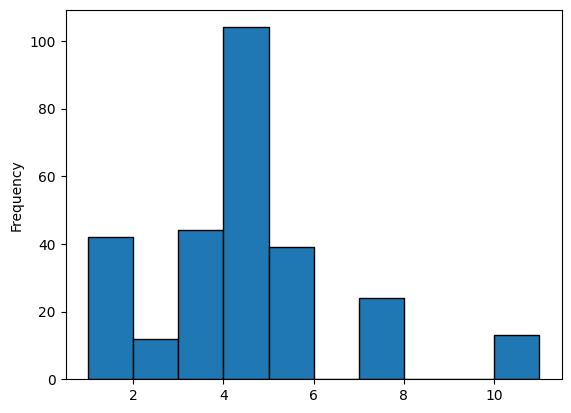

In [232]:
import matplotlib.pyplot as plt
data_series = pd.Series(count_nans)
data_series.plot(kind='hist', edgecolor='black')

plt.show()

Make a cutoff for only samples that have more than 1 cell of the type.

In [233]:
cutoff = pd.DataFrame(groups[groups > 1])
cutoff.groupby('Level_2_cancer').size()

Level_2_cancer
Airway epithelium_Normal      278
Airway epithelium_Tumor       265
Alveolar epithelium_Normal    278
Alveolar epithelium_Tumor     265
Blood vessels_Normal          278
Blood vessels_Tumor           173
Fibroblast lineage_Normal     278
Fibroblast lineage_Tumor       98
Lymphatic EC_Normal           278
Lymphatic EC_Tumor             94
Lymphoid_Normal               278
Lymphoid_Tumor                265
Mesothelium_Normal            260
Myeloid_Normal                278
Myeloid_Tumor                 241
Smooth muscle_Normal          278
Smooth muscle_Tumor           112
Submucosal Gland_Normal       172
Submucosal Gland_Tumor          6
Unknown_Normal                278
Unknown_Tumor                 265
dtype: int64

### Cells by type

In [234]:
cutoff.groupby('Level_2_cancer').sum()

,0
Level_2_cancer,
Airway epithelium_Normal,35910.0
Airway epithelium_Tumor,54582.0
Alveolar epithelium_Normal,38955.0
Alveolar epithelium_Tumor,4904.0
Blood vessels_Normal,38096.0
Blood vessels_Tumor,597.0
Fibroblast lineage_Normal,15388.0
Fibroblast lineage_Tumor,15.0
Lymphatic EC_Normal,4209.0


### Total cells:

In [235]:
cutoff.groupby('Level_2_cancer').sum().sum()

0    902653.0
dtype: float64

## Matrix of Samples by type

Now to get the mutual information we need to have a matrix where 
we can get the pointwise mutual information (relative entropy) of any
two cell types 
$$
\log{\frac{p(x,y)}{p(x)p(y)}}
$$.
To then get the expected value of those:
$$
\sum_{X,Y}{p(x,y)\log{\frac{p(x,y)}{p(x)p(y)}}}
$$.

The idea was to get a discrete mutual information, because we are getting counts of cells being present in the tisse to study.
Nevertheless, a discrete mutual information would just be constraining the states to present or not present, or some
discrete states that would nevertheless be ordered and so the ranking the aracne does suddenly seems the same.

Definitely just having present or not present would give us no info because at this level the clusters almost always have at least one cell.

In [236]:
groups

0
Level_2_cancer           sample                              
Airway epithelium_Normal P4_normal_adjacent_UKIM-V-2       56
                         P4_tumor_primary_UKIM-V-2         18
                         P5_normal_adjacent_UKIM-V-2       54
                         P5_tumor_primary_UKIM-V-2         33
                         P6_normal_adjacent_UKIM-V-2       22
...                                                       ...
Unknown_Tumor            NSCLC-7_Chen_Zhang_2020_NSCLC      0
                         NSCLC-8_Chen_Zhang_2020_NSCLC      0
                         NSCLC-9_Chen_Zhang_2020_NSCLC     27
                         NSCLC-10_Chen_Zhang_2020_NSCLC  1075
                         NSCLC-11_Chen_Zhang_2020_NSCLC     0

[4718 rows x 1 columns]

In [237]:
samp_type = groups.unstack().transpose()
samp_type

Level_2_cancer                              Airway epithelium_Normal  \
  sample                                                               
0 1247_Lambrechts_2018_LUAD_6149v1                               1.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                  98.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                  28.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                             0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                            23.0   
...                                                              ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                      44.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                          26.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                           2.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                           2.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                           1.0   

Level_2_cancer                              Airway epithelium_Tumor  \
  sample                                                              
0 1247_Lambrechts_2018_LUAD_6149v1                              1.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                  1.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                  0.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                           12.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                           44.0   
...                                                             ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                      0.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                          0.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                          7.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                          1.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                          1.0   

Level_2_cancer                              Alveolar epithelium_Normal  \
  sample                                                                 
0 1247_Lambrechts_2018_LUAD_6149v1                                70.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                     2.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                   307.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                               0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                              18.0   
...                                                                ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                       349.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                           204.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                            14.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                            36.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                             4.0   

Level_2_cancer                              Alveolar epithelium_Tumor  \
  sample                                                                
0 1247_Lambrechts_2018_LUAD_6149v1                                0.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                    0.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                    2.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                              0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                            266.0   
...                                                               ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                        0.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                            0.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                           29.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                            2.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                            1.0   

Level_2_cancer                              Blood vessels_Normal  \
  sample                                                           
0 1247_Lambrechts_2018_LUAD_6149v1                          31.0   
  BRONCHO_11_Kim_Lee_2

Checking the Lambrechts we see that their samples have very few cells, and the submucosal gland cluster is strange so it wasn't trasnferred.
This just means that effectively there are no cells with submocusal glands inthose adatas se we just replace them with zeros.

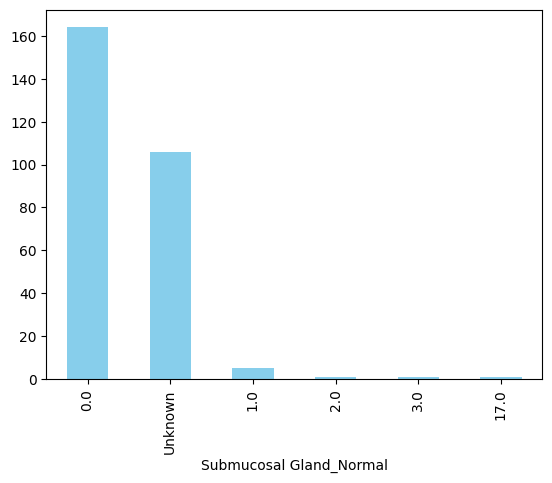

In [239]:
# Count the occurrences of each category
lol = samp_type['Submucosal Gland_Normal'].astype('category')
lol = lol.cat.add_categories('Unknown')
lol = lol.fillna('Unknown')

category_counts = lol.value_counts()

category_counts.plot(kind='bar', color='skyblue')
plt.show()

Most of it is 0's so we will remove that column. Also because our type annotation is very general,
we aren't getting very near to a limit of detection of our algorithm.
Though it would have to do with our uncertainty.

In [240]:
del samp_type['Submucosal Gland_Normal']
del samp_type['Submucosal Gland_Tumor']

By the way the transfer of the labels is done, if the cluster is not present the label does not appear. So it would be like a 0.

In [241]:
samp_type = samp_type.fillna(0)
samp_type

Level_2_cancer                              Airway epithelium_Normal  \
  sample                                                               
0 1247_Lambrechts_2018_LUAD_6149v1                               1.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                  98.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                  28.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                             0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                            23.0   
...                                                              ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                      44.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                          26.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                           2.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                           2.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                           1.0   

Level_2_cancer                              Airway epithelium_Tumor  \
  sample                                                              
0 1247_Lambrechts_2018_LUAD_6149v1                              1.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                  1.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                  0.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                           12.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                           44.0   
...                                                             ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                      0.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                          0.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                          7.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                          1.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                          1.0   

Level_2_cancer                              Alveolar epithelium_Normal  \
  sample                                                                 
0 1247_Lambrechts_2018_LUAD_6149v1                                70.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                     2.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                   307.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                               0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                              18.0   
...                                                                ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                       349.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                           204.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                            14.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                            36.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                             4.0   

Level_2_cancer                              Alveolar epithelium_Tumor  \
  sample                                                                
0 1247_Lambrechts_2018_LUAD_6149v1                                0.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                    0.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                    2.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                              0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                            266.0   
...                                                               ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                        0.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                            0.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                           29.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                            2.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                            1.0   

Level_2_cancer                              Blood vessels_Normal  \
  sample                                                           
0 1247_Lambrechts_2018_LUAD_6149v1                          31.0   
  BRONCHO_11_Kim_Lee_2

### Export for ARACNE AP

We export in a format that can be used for ARACNE AP, which has the 'genes' in the rows and only considers Target/TF pairs

In [242]:
aracne_types = samp_type.transpose()
aracne_types = pd.concat([aracne_types, aracne_types])
aracne_types.astype(int)
aracne_types.columns.name = None
aracne_types.index.name = 'genes'
aracne_types

0  \
sample                     1247_Lambrechts_2018_LUAD_6149v1   
genes                                                         
Airway epithelium_Normal                                1.0   
Airway epithelium_Tumor                                 1.0   
Alveolar epithelium_Normal                             70.0   
Alveolar epithelium_Tumor                               0.0   
Blood vessels_Normal                                   31.0   
Blood vessels_Tumor                                     0.0   
Fibroblast lineage_Normal                              11.0   
Fibroblast lineage_Tumor                                0.0   
Lymphatic EC_Normal                                     0.0   
Lymphatic EC_Tumor                                      0.0   
Lymphoid_Normal                                       122.0   
Lymphoid_Tumor                                          0.0   
Mesothelium_Normal                                      1.0   
Myeloid_Normal                                        105.0   
Myeloid_Tumor                                           0.0   
Smooth muscle_Normal                                    0.0   
Smooth muscle_Tumor                                     0.0   
Unknown_Normal                                          1.0   
Unknown_Tumor                                           0.0   
Airway epithelium_Normal                                1.0   
Airway epithelium_Tumor                                 1.0   
Alveolar epithelium_Normal                             70.0   
Alveolar epithelium_Tumor                               0.0   
Blood vessels_Normal                                   31.0   
Blood vessels_Tumor                                     0.0   
Fibroblast lineage_Normal                              11.0   
Fibroblast lineage_Tumor                                0.0   
Lymphatic EC_Normal                                     0.0   
Lymphatic EC_Tumor                                      0.0   
Lymphoid_Normal                                       122.0   
Lymphoid_Tumor                                          0.0   
Mesothelium_Normal                                      1.0   
Myeloid_Normal                                        105.0   
Myeloid_Tumor                                           0.0   
Smooth muscle_Normal                                    0.0   
Smooth muscle_Tumor                                     0.0   
Unknown_Normal                                          1.0   
Unknown_Tumor                                           0.0   

                                                         \
sample                     BRONCHO_11_Kim_Lee_2020_LUAD   
genes                                                     
Airway epithelium_Normal                           98.0   
Airway epithelium_Tumor                             1.0   
Alveolar epithelium_Normal                          2.0   
Alveolar epithelium_Tumor                           0.0   
Blood vessels_Normal                                2.0   
Blood vessels_Tumor                                 0.0   
Fibroblast lineage_Normal                           3.0   
Fibroblast lineage_Tumor                            0.0   
Lymphatic EC_Normal                                 3.0   
Lymphatic EC_Tumor                                  0.0   
Lymphoid_Normal                                  2222.0   
Lymphoid_Tumor                                      0.0   
Mesothelium_Normal                                  0.0   
Myeloid_Normal                                    733.0   
Myeloid_Tumor                                       0.0   
Smooth muscle_Normal                                0.0   
Smooth muscle_Tumor                                 0.0   
Unknown_Normal                                     77.0   
Unknown_Tumor                                       1.0   
Airway epithelium_Normal                           98.0   
Airway epithelium_Tumor                             1.0   
Alveolar epithelium_Normal                          2.0   

In [247]:
aracne_types.index

Index(['Airway epithelium_Normal', 'Airway epithelium_Tumor',
       'Alveolar epithelium_Normal', 'Alveolar epithelium_Tumor',
       'Blood vessels_Normal', 'Blood vessels_Tumor',
       'Fibroblast lineage_Normal', 'Fibroblast lineage_Tumor',
       'Lymphatic EC_Normal', 'Lymphatic EC_Tumor', 'Lymphoid_Normal',
       'Lymphoid_Tumor', 'Mesothelium_Normal', 'Myeloid_Normal',
       'Myeloid_Tumor', 'Smooth muscle_Normal', 'Smooth muscle_Tumor',
       'Unknown_Normal', 'Unknown_Tumor', 'Airway epithelium_Normal',
       'Airway epithelium_Tumor', 'Alveolar epithelium_Normal',
       'Alveolar epithelium_Tumor', 'Blood vessels_Normal',
       'Blood vessels_Tumor', 'Fibroblast lineage_Normal',
       'Fibroblast lineage_Tumor', 'Lymphatic EC_Normal', 'Lymphatic EC_Tumor',
       'Lymphoid_Normal', 'Lymphoid_Tumor', 'Mesothelium_Normal',
       'Myeloid_Normal', 'Myeloid_Tumor', 'Smooth muscle_Normal',
       'Smooth muscle_Tumor', 'Unknown_Normal', 'Unknown_Tumor'],
      dtype='obj

In [250]:
tfs = aracne_types.index[0:int(aracne_types.shape[0]/2)]

with open('tfs.txt', 'w') as f:
    for tf in tfs:
        f.write(str(tf) + '\n')

In [288]:
! cat tfs.txt

Airway epithelium_Normal
Airway epithelium_Tumor
Alveolar epithelium_Normal
Alveolar epithelium_Tumor
Blood vessels_Normal
Blood vessels_Tumor
Fibroblast lineage_Normal
Fibroblast lineage_Tumor
Lymphatic EC_Normal
Lymphatic EC_Tumor
Lymphoid_Normal
Lymphoid_Tumor
Mesothelium_Normal
Myeloid_Normal
Myeloid_Tumor
Smooth muscle_Normal
Smooth muscle_Tumor
Unknown_Normal
Unknown_Tumor


In [277]:
a = aracne_types.reset_index()
a.columns = a.columns.get_level_values('sample')
a = a.set_index([''])

In [278]:
a.to_csv('matrix.txt', sep='\t')

In [279]:
! head matrix.txt

	1247_Lambrechts_2018_LUAD_6149v1	BRONCHO_11_Kim_Lee_2020_LUAD	BRONCHO_58_Kim_Lee_2020_LUAD	BT1249_Lambrechts_2018_LUAD_6149v1	BT1290_Lambrechts_2018_LUAD_6149v2	BT1291_Lambrechts_2018_LUAD_6149v2	BT1292_Lambrechts_2018_LUAD_6149v2	BT1293_Lambrechts_2018_LUAD_6149v2	BT1294_Lambrechts_2018_LUAD_6149v2	BT1295_Lambrechts_2018_LUAD_6149v2	BT1296_Lambrechts_2018_LUAD_6149v2	BT1297_Lambrechts_2018_LUAD_6149v2	BT1298_Lambrechts_2018_LUAD_6149v2	BT1299_Lambrechts_2018_LUAD_6149v2	BT1300_Lambrechts_2018_LUAD_6149v2	BT1301_Lambrechts_2018_LUAD_6149v2	BT1375_Lambrechts_2018_LUAD_6653	BT1376_Lambrechts_2018_LUAD_6653	BT1377_Lambrechts_2018_LUAD_6653	BT1378_Lambrechts_2018_LUAD_6653	BT1A_Lambrechts_2018_LUAD_6149v1	BT1B_Lambrechts_2018_LUAD_6149v1	BT1C_Lambrechts_2018_LUAD_6149v1	BT2A_Lambrechts_2018_LUAD_6149v1	BT2B_Lambrechts_2018_LUAD_6149v1	EBUS_06_Kim_Lee_2020_LUAD	EBUS_10_Kim_Lee_2020_LUAD	EBUS_12_Kim_Lee_2020_LUAD	EBUS_13_Kim_Lee_2020_LUAD	EBUS_15_Kim_Lee_2020_LUAD	EBUS_19_Kim_Lee_2020_LUAD	

We use [ARACNE-AP](https://github.com/califano-lab/ARACNe-AP/tree/master) because it is fast 
and we dont need many libraries. Just JAVA. Downlaod the git repo and change the path to that.

First we must calculate the threshold

In [280]:
! java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -e matrix.txt  -o outputFolder \
    --tfs tfs.txt --pvalue 1E-8 --seed 1 --nobootstrap --nodpi \
    --calculateThreshold

MI threshold file was already there, but I am recalculating it.
Finding threshold for 278 samples
Parameters for fitted threshold function: [0.0910168539218434, 6.225412313320226E-6]
MI threshold: 0.1057896852797087


In [291]:
%%time
! java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -e matrix.txt  -o outputFolder \
    --tfs tfs.txt --pvalue 1E-8 --seed 1 --nobootstrap --nodpi

MI threshold file is present
Calculate network from: matrix.txt
TFs processed: 19
Time elapsed for calculating MI: 0 sec

Edges removed by DPI:	0
Final Network size:	51
Total time elapsed: 0 sec
CPU times: user 0 ns, sys: 118 ms, total: 118 ms
Wall time: 498 ms


In [298]:
! sed '1d' outputFolder/nobootstrap_network.txt > outputFolder/net.txt

In [299]:
! cat outputFolder/net.txt

Unknown_Normal	Blood vessels_Normal	0.13729032075046277
Unknown_Normal	Alveolar epithelium_Normal	0.15087458331136805
Unknown_Normal	Airway epithelium_Normal	0.27317302965124224
Unknown_Normal	Myeloid_Normal	0.11268837095216266
Lymphoid_Normal	Lymphatic EC_Normal	0.13135248070988936
Lymphoid_Normal	Alveolar epithelium_Normal	0.12084733653222024
Lymphoid_Normal	Myeloid_Normal	0.3299500184928439
Unknown_Tumor	Airway epithelium_Tumor	0.4032493118654852
Unknown_Tumor	Lymphoid_Tumor	0.21191695815766298
Unknown_Tumor	Blood vessels_Tumor	0.128240965469125
Unknown_Tumor	Myeloid_Tumor	0.12884472701797467
Unknown_Tumor	Alveolar epithelium_Tumor	0.2429406610238436
Smooth muscle_Normal	Blood vessels_Normal	0.22976999360673034
Smooth muscle_Normal	Unknown_Normal	0.10828121971910143
Smooth muscle_Normal	Fibroblast lineage_Normal	0.3019502664281477
Alveolar epithelium_Normal	Blood vessels_Normal	0.15420069543083859
Alveolar epithelium_Normal	Unknown_Normal	0.15470476116272636
Alveolar epithelium_Norm

## Paint network

In [284]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

In [300]:
G = nx.read_edgelist("outputFolder/net.txt", data=(("MI", str),), delimiter='\t')
list(G.edges(data=True))

[('Unknown_Normal', 'Blood vessels_Normal', {'MI': '0.12463461378838314'}),
 ('Unknown_Normal',
  'Alveolar epithelium_Normal',
  {'MI': '0.15470476116272636'}),
 ('Unknown_Normal', 'Airway epithelium_Normal', {'MI': '0.2695671294429811'}),
 ('Unknown_Normal', 'Myeloid_Normal', {'MI': '0.11268837095216266'}),
 ('Unknown_Normal', 'Smooth muscle_Normal', {'MI': '0.10828121971910143'}),
 ('Blood vessels_Normal',
  'Smooth muscle_Normal',
  {'MI': '0.23556375399043628'}),
 ('Blood vessels_Normal',
  'Alveolar epithelium_Normal',
  {'MI': '0.14815227951966037'}),
 ('Blood vessels_Normal',
  'Fibroblast lineage_Normal',
  {'MI': '0.3289425506333288'}),
 ('Blood vessels_Normal', 'Lymphatic EC_Normal', {'MI': '0.2675718688112303'}),
 ('Blood vessels_Normal', 'Myeloid_Normal', {'MI': '0.14709118677992095'}),
 ('Alveolar epithelium_Normal',
  'Lymphoid_Normal',
  {'MI': '0.12498129189228901'}),
 ('Alveolar epithelium_Normal',
  'Airway epithelium_Normal',
  {'MI': '0.16703179855562045'}),
 ('Alv

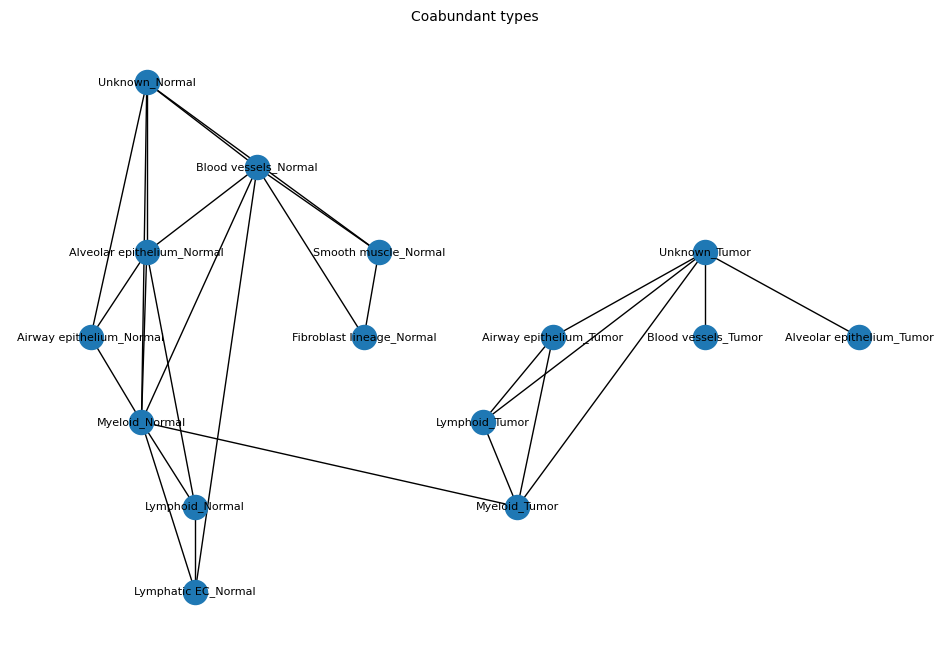

In [303]:
plt.figure(figsize=(12, 8))  # Set a larger figure size (width, height in inches)
plt.title('Coabundant types', fontsize=10)  # Smaller title font size

pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size=8)  # Smaller label font size
plt.savefig('coabundant_types2.png')

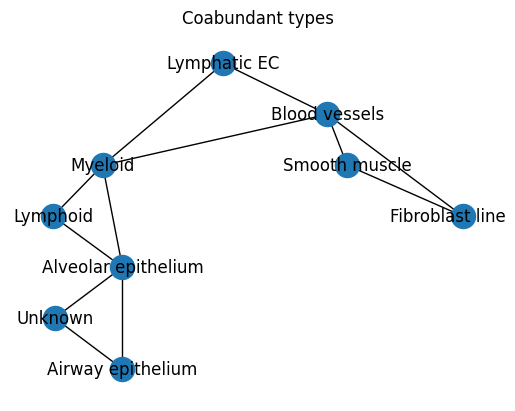

In [9]:
plt.title('Coabundant types')
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True)
plt.savefig('coabundant_types2.png')

Maybe we can do also mututal information of samples and see if clusters correlate with cancer or tissue type

### MI with sklearn (deprecated)

In [84]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

We won't use the function `mutual_info_score` because it is for labels assigned to a same observation. Which is not the case 
here because we are counting ocurrence of cells and no two cells should have more than one type.

So we use the `mutual_info_classif` though it is pretty unstable and does not use the same method than ARACNE.

**TODO:** compare the two methods, apparently n_neighbours is better at handling missing values?!?!?

To use discrete values we will rank the cell type in every sample based on a normalization by its total number of cells.

In [174]:
cells_x_sample = samp_type.transpose().sum().to_numpy()
percents = (samp_type / cells_x_sample.reshape(-1,1))*10
percents = percents.astype(int)
percents

Level_2_transfered_label,Airway epithelium,Alveolar epithelium,Blood vessels,Fibroblast lineage,Lymphatic EC,Lymphoid,Mesothelium,Myeloid,Smooth muscle,Unknown
sample,,,,,,,,,,
1247_Lambrechts,0,2,0,0,0,3,0,3,0,0
BRONCHO_11_Kim,0,0,0,0,0,7,0,2,0,0
BRONCHO_58_Kim,0,1,0,0,0,6,0,1,0,0
BT1249_Lambrechts,1,0,0,3,0,2,0,2,0,0
BT1A_Lambrechts,1,0,0,0,0,5,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
patient_45_tumor_primary_Goveia,0,0,4,0,0,0,0,0,0,2
patient_46_normal_adjacent_Goveia,0,0,1,0,0,0,0,6,0,0
patient_46_tumor_primary_Goveia,1,1,2,0,0,0,0,0,0,2


Lets try with 10 ranks first. We should maybe look at the histogram to define the ranks but later.

In [167]:
percents.quantile([0.25,0.5,0.75])

Level_2_transfered_label,Airway epithelium,Alveolar epithelium,Blood vessels,Fibroblast lineage,Lymphatic EC,Lymphoid,Mesothelium,Myeloid,Smooth muscle,Unknown
0.25,0.555112,0.095459,0.080835,0.090000,0.000000,12.106691,0.0,12.803444,0.000000,1.073977
0.50,2.155407,1.019274,0.441795,0.530837,0.000000,35.717875,0.0,25.158388,0.049634,3.158462
0.75,11.011905,4.148505,1.565885,2.462523,0.107153,60.486871,0.0,44.321183,0.238419,9.326886


In [180]:
mis = []

for col in percents.columns:
    
    mis.append(mutual_info_classif(percents.to_numpy(),percents[col].to_numpy().reshape(-1,1)))
    
pd.DataFrame(mis, columns=percents.columns, index = percents.columns)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Level_2_transfered_label,Airway epithelium,Alveolar epithelium,Blood vessels,Fibroblast lineage,Lymphatic EC,Lymphoid,Mesothelium,Myeloid,Smooth muscle,Unknown
Level_2_transfered_label,,,,,,,,,,
Airway epithelium,1.054760e+00,5.498831e-01,3.326694e-01,4.077500e-01,1.264831e-01,1.390151e-01,4.939621e-01,4.922736e-02,4.321303e-01,0.000000e+00
Alveolar epithelium,0.000000e+00,6.438520e-01,2.373198e-01,2.415227e-01,4.240108e-02,6.390419e-02,3.454416e-01,7.780823e-02,2.860061e-01,2.874398e-02
Blood vessels,1.268936e-02,2.330745e-01,3.365842e-01,3.073920e-01,2.537583e-01,2.804300e-02,2.768843e-01,0.000000e+00,3.217768e-01,0.000000e+00
Fibroblast lineage,2.326619e-03,5.747926e-02,1.472116e-01,3.696483e-01,1.481677e-01,2.477861e-03,2.179479e-01,1.900580e-03,2.129614e-01,1.731524e-02
Lymphatic EC,0.000000e+00,0.000000e+00,8.131330e-03,0.000000e+00,4.811499e-02,0.000000e+00,3.892864e-02,0.000000e+00,4.155331e-02,2.374098e-03
Lymphoid,1.483189e-01,9.485741e-02,6.735740e-02,0.000000e+00,1.098557e-01,1.333505e+00,6.050899e-02,4.374144e-01,3.717078e-02,1.221909e-01
Mesothelium,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
Myeloid,1.562561e-02,2.437624e-01,2.578793e-02,1.247594e-01,9.637084e-02,3.219901e-01,0.000000e+00,1.492556e+00,8.698299e-02,1.098791e-01
Smooth muscle,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16


tener las unidades en bits te sirve para comparar que tantos bits pueden compartir dos cosas

This binning is not as efficient as the one from ARACNE because the Gaussina copula method considers variance also, besides the static width. So we will use the method from ARACNE and in that way, we also wont have to normalize for ourselves.